<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Hyperparameter Tuning

## *Data Science Unit 4 Sprint 2 Assignment 4*

## Your Mission, should you choose to accept it...

To hyperparameter tune and extract every ounce of accuracy out of this telecom customer churn dataset: [Available Here](https://lambdaschool-data-science.s3.amazonaws.com/telco-churn/WA_Fn-UseC_-Telco-Customer-Churn+(1).csv)

## Requirements

- Load the data ✔
- Clean the data if necessary (it will be) ✔
- Create and fit a baseline Keras MLP model to the data. ✔
- Hyperparameter tune (at least) the following parameters:
 - batch_size ✔
 - training epochs ✔
 - optimizer ✔
 - learning rate (if applicable to optimizer) ✔
 - momentum (if applicable to optimizer) ✔ (Not Applicable)
 - activation functions ✔
 - network weight initialization ✔
 - dropout regularization ✔
 - number of neurons in the hidden layer ✔
 
 You must use Grid Search and Cross Validation for your initial pass of the above hyperparameters
 
 Try and get the maximum accuracy possible out of this data! You'll save big telecoms millions! Doesn't that sound great?


In [0]:
# Load and Clean Data

In [1]:
# Imports
import pandas as pd
import numpy as np

# Fix random seed for reproducibility
seed = 7
np.random.seed(seed)

url = 'https://lambdaschool-data-science.s3.amazonaws.com/telco-churn/WA_Fn-UseC_-Telco-Customer-Churn+(1).csv'
    
df = pd.read_csv(url)

df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [2]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [2]:
df['TotalCharges'] = df['TotalCharges'].replace(' ', np.NaN) # Replace spaces with NaN

df['TotalCharges'] = df['TotalCharges'].astype(float)

df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

In [0]:
# Drop NA values.
df = df.dropna()

# customerID is irrelevant and will affect model accuracy. Let's drop it.

df = df.drop(columns='customerID')

In [5]:
df.sample(10)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
2411,Male,0,No,Yes,60,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Two year,Yes,Electronic check,84.95,4984.85,No
5118,Female,0,Yes,No,42,Yes,Yes,Fiber optic,No,No,Yes,Yes,No,No,Month-to-month,Yes,Credit card (automatic),85.90,3729.75,No
5724,Male,0,No,No,1,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,71.35,71.35,Yes
4774,Female,0,Yes,No,53,Yes,Yes,Fiber optic,No,No,No,Yes,No,Yes,One year,Yes,Electronic check,91.15,4862.50,No
1877,Male,0,No,No,72,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),88.55,6362.35,No
131,Female,0,Yes,Yes,25,No,No phone service,DSL,Yes,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Credit card (automatic),58.60,1502.65,Yes
5631,Male,0,Yes,No,3,No,No phone service,DSL,No,No,No,No,No,No,Month-to-month,No,Mailed check,25.00,78.25,No
4028,Male,0,No,No,63,Yes,No,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),109.20,7049.75,No
5588,Male,0,No,No,1,Yes,No,DSL,No,No,Yes,No,No,No,Month-to-month,Yes,Mailed check,49.65,49.65,Yes
3013,Female,0,No,No,29,Yes,Yes,DSL,No,No,No,No,Yes,Yes,One year,Yes,Credit card (automatic),71.00,2080.10,No


# Baseline Keras Model

In [4]:
# Imports
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf

X = df.drop(columns='Churn')  # Features
y = df['Churn']

encoder = LabelEncoder()

X_enc = X.apply(encoder.fit_transform)
y_enc = encoder.fit_transform(y)


print('Encoded X Shape:', X_enc.shape)
print('Encoded y Shape:', y_enc.shape)

Encoded X Shape: (7032, 19)
Encoded y Shape: (7032,)


In [0]:
# Scale our data.

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X_enc)

In [6]:
# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_enc, test_size=0.33, random_state=42)

print(f'X_train Shape: {X_train.shape}')
print(f'y_train Shape: {y_train.shape}')

print('')

print(f'X_test Shape: {X_test.shape}')
print(f'y_test Shape: {y_test.shape}')

X_train Shape: (4711, 19)
y_train Shape: (4711,)

X_test Shape: (2321, 19)
y_test Shape: (2321,)


In [0]:
# Baseline Model

bl_model = Sequential([
                       Dense(20, activation='relu', input_dim=X_train.shape[1], name='InputLayer'),
                       Dense(20, activation='relu', name='Hidden1'),
                       Dense(20, activation='relu', name='Hidden2'),
                       Dense(1, activation='sigmoid', name='OutputLayer')
])

bl_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

bl_model_fit = bl_model.fit(X_train, y_train, epochs=50, verbose=False)

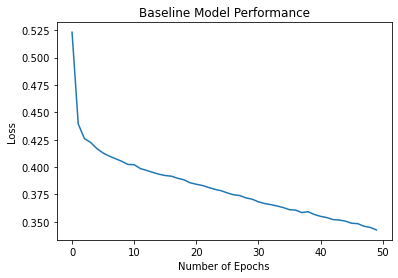

In [8]:
# Check out model performance
import matplotlib.pyplot as plt
plt.plot(bl_model_fit.history['loss'])
plt.title('Baseline Model Performance')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.show();

# Hyperparameter Tuning

In [0]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Dropout
import warnings

warnings.filterwarnings("ignore", category=UserWarning)  # Ignore UserWarnings

# Create model wrapper
def create_model_initial(n_neurons=20, optimizer='adam', learning_rate=0.1,
                 activation='relu', init_mode='glorot_uniform',
                dropout_rate=0.0):
    
    # Instantiate Model
    model = Sequential()
    
    # Input Layer
    model.add(Dense(n_neurons, activation=activation, 
                    kernel_initializer=init_mode, 
                    input_dim=X_train.shape[1], name='InputLayer'))
    # Hidden Layers
    model.add(Dense(n_neurons, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n_neurons, activation=activation))
    model.add(Dropout(dropout_rate))
    
    # Output Layer
    model.add(Dense(1, activation='sigmoid', name='OutputLayer'))
    
    # Compile our Model
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
              
    return model

## Batch Size

In [10]:
# Define Grid Search Parameters
model = KerasClassifier(build_fn=create_model_initial, verbose=False)

param_grid = {
               'batch_size': [10, 25, 50, 75, 100, 200, 250, 350, 500],
               'epochs': [50]
             }

gridcv = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
gridcv_result = gridcv.fit(X_train, y_train)

print(f"Best: {gridcv_result.best_score_} using {gridcv_result.best_params_}")
batch_size = gridcv_result.best_params_['batch_size']

Best: 0.7970709800720215 using {'batch_size': 200, 'epochs': 50}


## Epochs

In [11]:
# Define Grid Search Parameters
param_grid = {
               'batch_size': [batch_size],
               'epochs': [25, 50, 75, 100, 125, 150, 200, 250]
}

gridcv = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
gridcv_result = gridcv.fit(X_train, y_train)

print(f"Best: {gridcv_result.best_score_} using {gridcv_result.best_params_}")
epochs = gridcv_result.best_params_['epochs']

Best: 0.7904924949010214 using {'batch_size': 200, 'epochs': 75}


## Optimizer

In [12]:
# Define Grid Search Parameters
param_grid = {
               'batch_size': [batch_size],
               'epochs': [epochs],
               'optimizer': ['adam', 'adamax', 'nadam', 'adagrad', 'adadelta', 'rmsprop']
}

gridcv = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
gridcv_result = gridcv.fit(X_train, y_train)

print(f"Best: {gridcv_result.best_score_} using {gridcv_result.best_params_}")
optimizer = gridcv_result.best_params_['optimizer']

Best: 0.793462852636973 using {'batch_size': 200, 'epochs': 75, 'optimizer': 'adamax'}


## Learning Rate

In [0]:
def create_model(n_neurons=20, optimizer='rmsprop', learning_rate=0.1,
                 activation='relu', init_mode='glorot_uniform',
                dropout_rate=0.0):
    
    # Instantiate Model
    model = Sequential()
    
    # Input Layer
    model.add(Dense(n_neurons, activation=activation, 
                    kernel_initializer=init_mode, 
                    input_dim=X_train.shape[1], name='InputLayer'))
    # Hidden Layers
    model.add(Dense(n_neurons, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n_neurons, activation=activation))
    model.add(Dropout(dropout_rate))
    
    # Output Layer
    model.add(Dense(1, activation='sigmoid', name='OutputLayer'))
    
    optimizer = tf.optimizers.Adamax(lr=learning_rate)  # This is what I updated.
    
    # Compile our Model
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
              
    return model

model = KerasClassifier(build_fn=create_model, verbose=False)  # Build new model

In [14]:
# Define Grid Search Parameters
param_grid = {
               'batch_size': [batch_size],
               'epochs': [epochs],
               'optimizer': [optimizer],
               'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.25, 0.35, 0.45, 0.5]
}

gridcv = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
gridcv_result = gridcv.fit(X_train, y_train)

print(f"Best: {gridcv_result.best_score_} using {gridcv_result.best_params_}")
learning_rate = gridcv_result.best_params_['learning_rate']

Best: 0.7966467539469401 using {'batch_size': 200, 'epochs': 75, 'learning_rate': 0.001, 'optimizer': 'adamax'}


## Momentum

In [0]:
# Not a hyperparameter of Adamax

## Activation Functions

In [16]:
# Define Grid Search Parameters
param_grid = {
               'batch_size': [batch_size],
               'epochs': [epochs],
               'optimizer': [optimizer],
               'learning_rate': [learning_rate],
               'activation': ['relu', 'leakyrelu', 'selu', 'elu']
}

gridcv = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
gridcv_result = gridcv.fit(X_train, y_train)

print(f"Best: {gridcv_result.best_score_} using {gridcv_result.best_params_}")
activation = gridcv_result.best_params_['activation']

Best: 0.7987692356109619 using {'activation': 'elu', 'batch_size': 200, 'epochs': 75, 'learning_rate': 0.001, 'optimizer': 'adamax'}


## Weight Initialization

In [17]:
# Define Grid Search Parameters
param_grid = {
               'batch_size': [batch_size],
               'epochs': [epochs],
               'optimizer': [optimizer],
               'learning_rate': [learning_rate],
               'activation': [activation],
               'init_mode': ['uniform', 'lecun_uniform', 'normal',
                            'zero', 'glorot_normal', 'glorot_uniform',
                            'he_normal', 'he_uniform']
}

gridcv = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
gridcv_result = gridcv.fit(X_train, y_train)

print(f"Best: {gridcv_result.best_score_} using {gridcv_result.best_params_}")
init_mode = gridcv_result.best_params_['init_mode']

Best: 0.8059862852096558 using {'activation': 'elu', 'batch_size': 200, 'epochs': 75, 'init_mode': 'normal', 'learning_rate': 0.001, 'optimizer': 'adamax'}


## Dropout Regularization

In [18]:
# Define Grid Search Parameters
param_grid = {
               'batch_size': [batch_size],
               'epochs': [epochs],
               'optimizer': [optimizer],
               'learning_rate': [learning_rate],
               'activation': [activation],
               'init_mode': [init_mode],
               'dropout_rate': [0.01, 0.025, 0.3, 0.4, 0.05, 0.1, 0.2]
}

gridcv = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
gridcv_result = gridcv.fit(X_train, y_train)

print(f"Best: {gridcv_result.best_score_} using {gridcv_result.best_params_}")
dropout_rate = gridcv_result.best_params_['dropout_rate']

Best: 0.8055615226427714 using {'activation': 'elu', 'batch_size': 200, 'dropout_rate': 0.01, 'epochs': 75, 'init_mode': 'normal', 'learning_rate': 0.001, 'optimizer': 'adamax'}


## Number of Neurons

In [19]:
# Define Grid Search Parameters
param_grid = {
               'batch_size': [batch_size],
               'epochs': [epochs],
               'optimizer': [optimizer],
               'learning_rate': [learning_rate],
               'activation': [activation],
               'init_mode': [init_mode],
               'dropout_rate': [dropout_rate],
               'n_neurons': [25, 50, 75, 100, 125, 150, 200, 250, 500]
}

gridcv = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
gridcv_result = gridcv.fit(X_train, y_train)

print(f"Best: {gridcv_result.best_score_} using {gridcv_result.best_params_}")
n_neurons = gridcv_result.best_params_['n_neurons']

Best: 0.8053503036499023 using {'activation': 'elu', 'batch_size': 200, 'dropout_rate': 0.01, 'epochs': 75, 'init_mode': 'normal', 'learning_rate': 0.001, 'n_neurons': 75, 'optimizer': 'adamax'}


# Final Results! (Model Evaluation)

In [20]:
model = create_model(n_neurons=n_neurons, optimizer=optimizer, learning_rate=learning_rate,
                     activation=activation, init_mode=init_mode, dropout_rate=dropout_rate)

model.fit(X_train, y_train, epochs=epochs, verbose=False)

model_results = model.evaluate(X_test, y_test, verbose=False)

print('Model Accuracy:', f'{round(model_results[1] * 100, 3)}%')
print('======================================')
print('Achieved With Parameters:')
print('Number of Epochs:', epochs)
print('Batch Size:', batch_size)
print('Optimizer:', optimizer, f'(Learning Rate: {learning_rate})')
print('Activation Function:', activation)
print('Weight Initialization:', init_mode)
print('Dropout Rate:', dropout_rate)
print('Number of Neurons:', n_neurons)

Model Accuracy: 79.449%
Achieved With Parameters:
Number of Epochs: 75
Batch Size: 200
Optimizer: adamax (Learning Rate: 0.001)
Activation Function: elu
Weight Initialization: normal
Dropout Rate: 0.01
Number of Neurons: 75


# Stretch: Tuning Multiple at Once

In [44]:
# I'm doing this to see how much it affects accuracy. Using RandomizedSearchCV for compute time / resources - GridSearchCV will bring better accuracy, so I'm keeping this in mind.
from sklearn.model_selection import RandomizedSearchCV

model = KerasClassifier(build_fn=create_model_initial, verbose=False)

param_grid = {
               'batch_size': [10, 25, 50, 100, 150, 200, 250, 350, 500, 1000],
               'epochs': [25, 50, 100, 250],
               'optimizer': ['adam', 'adamax', 'nadam', 'adagrad', 'adadelta', 'rmsprop'],
               'activation': ['relu', 'leakyrelu', 'selu', 'elu']

}

rscv = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_jobs=-1, cv=3)
rscv_result = rscv.fit(X_train, y_train, validation_data=(X_test, y_test))  # Validating against test data, next will do a validation split.

print(f"Best: {rscv_result.best_score_} using {rscv_result.best_params_}")
optimizer = rscv_result.best_params_['optimizer']  # I guess an if statement within the model creation function would be the best for making this as seamless as possible as different optimizers have different hyperparameters.
epochs = rscv_result.best_params_['epochs']
batch_size = rscv_result.best_params_['batch_size']
activation = rscv_result.best_params_['activation']

Best: 0.8000439206759135 using {'optimizer': 'adamax', 'epochs': 100, 'batch_size': 150, 'activation': 'elu'}


In [46]:
model = KerasClassifier(build_fn=create_model, verbose=False)  # Updated to wrapper with learning rate included. Again with the if statement thing stated earlier.

param_grid = {
               'batch_size': [batch_size],
               'epochs': [epochs],
               'optimizer': [optimizer],
               'activation': [activation],
              'init_mode': ['uniform', 'lecun_uniform', 'normal',
                            'zero', 'glorot_normal', 'glorot_uniform',
                            'he_normal', 'he_uniform'],
               'dropout_rate': [0.01, 0.025, 0.3, 0.4, 0.05, 0.1, 0.2],
               'learning_rate': [0.0001, 0.001, 0.01, 0.025, 0.05, 0.1, 0.2, 0.25],
               'n_neurons': [50, 75, 100, 200, 250, 500, 1000]}

rscv = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_jobs=-1, cv=3)
rscv_result = rscv.fit(X_train, y_train, validation_split=0.2)  # Validation split of 20% as a different way to cross-validate here.

print(f"Best: {rscv_result.best_score_} using {rscv_result.best_params_}")
dropout_rate = rscv_result.best_params_['dropout_rate']
learning_rate = rscv_result.best_params_['learning_rate']
n_neurons = rscv_result.best_params_['n_neurons']
init_mode = rscv_result.best_params_['init_mode']

Best: 0.8013159235318502 using {'optimizer': 'adamax', 'n_neurons': 50, 'learning_rate': 0.0001, 'init_mode': 'glorot_uniform', 'epochs': 100, 'dropout_rate': 0.025, 'batch_size': 150, 'activation': 'elu'}


## Stretch Model Evaluation

In [47]:
model = create_model(n_neurons=n_neurons, optimizer=optimizer, learning_rate=learning_rate,
                     activation=activation, init_mode=init_mode, dropout_rate=dropout_rate)

model.fit(X_train, y_train, epochs=epochs, verbose=False)

model_results = model.evaluate(X_test, y_test, verbose=False)


# Previous Model Accuracy: 79.449% having used GridSearchCV, which to re-iterate, inherently grants better accuracy (also longer compute time & resources)
print('Model Accuracy:', f'{round(model_results[1] * 100, 3)}%')
print('======================================')
print('Achieved With Parameters:')
print('Number of Epochs:', epochs)
print('Batch Size:', batch_size)
print('Optimizer:', optimizer, f'(Learning Rate: {learning_rate})')
print('Activation Function:', activation)
print('Weight Initialization:', init_mode)
print('Dropout Rate:', dropout_rate)
print('Number of Neurons:', n_neurons)

Model Accuracy: 80.741%
Achieved With Parameters:
Number of Epochs: 100
Batch Size: 150
Optimizer: adamax (Learning Rate: 0.0001)
Activation Function: elu
Weight Initialization: glorot_uniform
Dropout Rate: 0.025
Number of Neurons: 50


## Stretch Goals:

- Try to implement Random Search Hyperparameter Tuning on this dataset ✔
- Try to implement Bayesian Optimiation tuning on this dataset using hyperas or hyperopt (if you're brave)
- Practice hyperparameter tuning other datasets that we have looked at. How high can you get MNIST? Above 99%?
- Study for the Sprint Challenge ✔
 - Can you implement both perceptron and MLP models from scratch with forward and backpropagation? ✔
 - Can you implement both perceptron and MLP models in keras and tune their hyperparameters with cross validation? ✔